# 同時に最適化する方法

-------------
### ライブラリのインポート＆その他の設定（Importing Libraries & Other Settings）

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

# 計算時間
import time

--------
### 実験設定

In [2]:
TARGET = "GMV"  # "GMV"か"BCR"
DATA = "part"  # "all" or "part"
DATA_SIZE = 2000  # データサイズ(訓練データとテストデータあわせて）
TEST_SIZE = 0.5  # テストデータの比率
THRESHOLD = 2  # 外れ値除外の閾値

SAMPLE_SIZE = 100  # 標本サイズ
N_TRIALS = 10  # 試行回数（標本平均を求める回数）
N_EXPERIMENT = 1  # 同じ特徴量が選択されるか確認したいときは２以上にする
m_VALUE = 2  # 各クラスタの最小標本数(最適標本配分)
RANDOM_STATE = 0  # 乱数シード

ALLOCATION_METHODS = [
    "Proportional",
    # "Post",
    # "Optimal",
]  # Randomはいれない #時間を測る場合は１つにする
CLUSTERING_METHOD = "kmeans"  # "gmm" or "kmeans" or "xmeans"
CRITERION = "VRR"  # "EVRR" か　"VRR" か "Var"(Var の評価はVRR)

if CRITERION == "EVRR":
    if CLUSTERING_METHOD == "kmeans":
        CLUSTERING_METHOD_NAME = "SFS-Kmeans-EVRR"
    if CLUSTERING_METHOD == "xmeans":
        CLUSTERING_METHOD_NAME == "SFS-Xmeans-EVRR"
    if CLUSTERING_METHOD == "gmm":
        CLUSTERING_METHOD_NAME == "SFS-GMM-EVRR"
if CRITERION == "VRR":
    if CLUSTERING_METHOD == "kmeans":
        CLUSTERING_METHOD_NAME = "SFS-Kmeans-VRR"
    if CLUSTERING_METHOD == "xmeans":
        CLUSTERING_METHOD_NAME == "SFS-Xmeans-VRR"
    if CLUSTERING_METHOD == "gmm":
        CLUSTERING_METHOD_NAME == "SFS-GMM-VRR"
if CRITERION == "Var":
    if CLUSTERING_METHOD == "kmeans":
        CLUSTERING_METHOD_NAME = "SFS-Kmeans-Var"
    if CLUSTERING_METHOD == "xmeans":
        CLUSTERING_METHOD_NAME == "SFS-Xmeans-Var"
    if CLUSTERING_METHOD == "gmm":
        CLUSTERING_METHOD_NAME == "SFS-GMM-Var"

# クラスタを固定する場合(gmm, kmeans)
N_CLUSTERS = 10  # クラスタ数
# クラスタ数を固定しない場合（xmeans)
K_MIN = 2
K_MAX = 10


MAXIMUM_FEATURES_TO_SELECT = 5  # 選択される最大の特徴量数

SELECTING_FEATURES = "all_features"  # 特徴量をmaxになるまで選ぶ⇒"all_features" or 基準値が最大になるまで⇒"not_all_features"


-----------
### データの前処理（Data Preprocessing）

##### 外れ値を除去する関数

In [3]:
# 外れ値の除去
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float = 2
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

##### メルカリデータ（df1：全部, df2：一部）

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)

features_list = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]

##### 外れ値除去

In [5]:
if DATA == "all":
    df = df1
if DATA == "part":
    df = df2

df["BCR"] = np.where(df["GMV"] > 0, 1, 0)

# 外れ値除去
df = remove_outliers_zscore(data=df, metric=TARGET, threshold=THRESHOLD)

X_all = df[features_list]
y_all = df[TARGET]

# 行を詰める
df = df.reset_index(drop=True)

print("外れ値除外前のデータ数（訓練+テスト）:", DATA_SIZE)
print("外れ値除外後のデータ数（訓練+テスト）:", len(df))


外れ値除外前のデータ数（訓練+テスト）: 2000
外れ値除外後のデータ数（訓練+テスト）: 1979


C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_3716\1333479718.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["BCR"] = np.where(df["GMV"] > 0, 1, 0)


##### 訓練テストの分割と標準化

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=0
)

print("訓練データのデータ数:", len(X_train))
print("テストデータのデータ数:", len(X_test))

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


訓練データのデータ数: 989
テストデータのデータ数: 990


-------------------------
### 単純無作為抽出（Random）の誤差分散を計算

In [7]:
RANDOM_STD_LIST = []
for exp in range(N_EXPERIMENT):
    y_hats = []
    np.random.seed(exp)
    for random_state in range(N_TRIALS):
        sample = np.random.choice(y_train, SAMPLE_SIZE, replace=False)
        y_hat_random = sample.mean()
        y_hats.append(y_hat_random)
    if CRITERION == "EVRR":
        errors = np.array(y_hats) - y_train.mean()
        random_std = errors.var()
    if CRITERION == "VRR" or "Var":
        random_std = np.array(y_hats).var()
    RANDOM_STD_LIST.append(random_std)

print("ランダムの誤差分散", RANDOM_STD_LIST)

ランダムの誤差分散 [406188.81372499996]


-------------
### 提案手法でクラスタリングと特徴量選択と標本配分

##### Allocation_in_Wrapper Class

In [8]:
class Allocation_in_Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        maximum_features_to_select: int,
        n_clusters: int,
        clustering_method: str = "kmeans",
        criterion: str = "EVRR",
        allocation_methods: list[str] = ["Proportional"],
        sample_size: int = 10,
        n_trials: int = 100,
        m_value=2,
        M: Optional[NDArray] = None,
        random_state: int = 0,
        selecting_features: str = "all_features",
        k_min: int = 2,
        k_max: int = 10,
        random_allocation_std: float = 0.1,
    ):
        self.maximum_features_to_select = maximum_features_to_select
        self.n_clusters = n_clusters
        self.clustering_method = clustering_method
        self.criterion = criterion
        self.allocation_methods = allocation_methods
        self.sample_size = sample_size
        self.n_trials = n_trials
        self.m_value = m_value
        self.M = M
        self.random_state = random_state
        self.selecting_features = selecting_features
        self.k_min = k_min
        self.k_max = k_max
        self.random_allocation_std = random_allocation_std

    def fss(self, X: pd.DataFrame, y: pd.DataFrame) -> "Allocation_in_Wrapper":
        X, y = check_X_y(X, y)
        n_all_features = X.shape[1]  # 総特徴量数
        self.final_selected_features_dict = {}  # キー：標本配分手法, 値：最終的に選ばれた特徴量のリスト
        self.final_cluster_assignments_dict = {}  # キー：標本配分手法, 値：最終的なクラスタラベル
        self.features_score_dict_dict = {}  # キー：標本配分手法, 値：features_score_dict
        self.features_variance_dict_dict = {}  # キー：標本配分手法, 値：features_error_variance_dict
        self.final_n_clusters_dict = {}  # キー：標本配分手法, 値：最終的なクラスタ数
        self.final_score_dict = {}
        self.final_variance_dict = {}

        # 特徴量選択
        for allocation_method in self.allocation_methods:
            print("[", allocation_method, "]")

            features_score_dict = {}
            features_variance_dict = {}

            # 選ばれた特徴量と残っている特徴量の初期化
            current_features = []
            remaining_features = list(range(n_all_features))

            if self.selecting_features == "not_all_features":
                if self.criterion == "EVRR" or "VRR":
                    best_score = -np.inf

            while len(current_features) < self.maximum_features_to_select:
                if self.selecting_features == "all_features":
                    if self.criterion == "EVRR" or "VRR":
                        best_score = -np.inf

                best_feature = None  # 選ぶ特徴量の初期化

                for feature in remaining_features:
                    temp_features = current_features + [
                        feature
                    ]  # 特徴量をひとつ加え、score計算
                    score, variance, n_clusters = self.crit(
                        X[:, temp_features], y, allocation_method
                    )

                    if score > best_score:
                        best_score = score
                        best_variance = variance
                        best_feature = feature
                        best_labels = self.N_cluster_label
                        best_N_cluster_size = self.N_cluster_size
                        best_n_clusters = n_clusters
                        best_n_cluster_size = self.n_cluster_size

                if best_feature is not None:
                    current_features.append(best_feature)
                    num_of_features = len(current_features)
                    print(
                        "num_of_features:",
                        num_of_features,
                        "current_features:",
                        current_features,
                        ", score:",
                        best_score,
                        "best_n_clusters:",
                        best_n_clusters,
                        "best_N_cluster_size:",
                        best_N_cluster_size,
                        "best_n_cluster_size:",
                        best_n_cluster_size,
                    )

                    features_score_dict[str(num_of_features)] = best_score  # 確認用
                    features_variance_dict[str(num_of_features)] = best_variance

                    remaining_features.remove(best_feature)
                    self.selected_features_ = current_features
                else:
                    break

            self.final_cluster_assignments_dict[allocation_method] = best_labels
            self.final_n_clusters_dict[allocation_method] = best_n_clusters
            self.final_selected_features_dict[allocation_method] = (
                self.selected_features_
            )
            self.features_score_dict_dict[allocation_method] = features_score_dict
            self.features_variance_dict_dict[allocation_method] = features_variance_dict
            self.final_score_dict[allocation_method] = best_score
            self.final_variance_dict[allocation_method] = best_variance

        return self

    def crit(self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str) -> float:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            model = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
        # クラスタリング手法がKMEANSの場合
        if self.clustering_method == "kmeans":
            model = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
        if self.clustering_method == "xmeans":
            model = self.xmeans(X)

        model.fit(X)
        self.N_cluster_label = model.predict(X)
        self.N_cluster_size = np.bincount(self.N_cluster_label)
        n_clusters = len(np.unique(self.N_cluster_label))

        variance, reduction_rate = self.cauculate_reduction_rate(
            X, y, allocation_method
        )
        if reduction_rate is None:
            score = -variance
        else:
            score = reduction_rate

        return score, variance, n_clusters

    def compute_bic(self, X: pd.DataFrame, kmeans):
        # クラスタリング結果の取得
        labels = kmeans.labels_
        clusters = kmeans.cluster_centers_
        n_clusters = len(clusters)
        n = len(X)
        m = X.shape[1]
        # クラスター内の分散の合計
        variance = np.sum(
            [
                np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
                for i in range(n_clusters)
            ]
        )
        # BIC の計算
        bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
        return bic

    def xmeans(self, X: pd.DataFrame):
        kmeans = KMeans(
            n_clusters=self.k_min, random_state=self.random_state
        )  # 初期クラスター数で KMeans を実行
        kmeans.fit(X)
        best_bic = self.compute_bic(X, kmeans)
        best_kmeans = kmeans
        for k in range(self.k_min + 1, self.k_max + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(X)
            # BIC を計算
            current_bic = self.compute_bic(X, kmeans)
            # BIC が改善される場合、クラスタ数を更新
            if current_bic < best_bic:
                best_bic = current_bic
                best_kmeans = kmeans
        # 最適なクラスタリング結果を返す
        return best_kmeans

    def cauculate_reduction_rate(
        self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str
    ) -> float:
        # 各戦略の標本数に基づいて目的変数の平均を推定
        y_hats = []
        for random_state in range(self.n_trials):
            if allocation_method == "Post":
                y_hat = self.estimate_y_mean_post(X, y)
            else:
                y_hat = self.estimate_y_mean_other(X, y, allocation_method)
            y_hats.append(
                {
                    "policy": allocation_method,
                    "y_hat": y_hat,
                    "random_state": random_state,
                }
            )

        y_hat_df = pd.DataFrame(y_hats)

        if self.criterion == "EVRR":
            y_hat_df["error"] = (
                y_hat_df["y_hat"] - y.mean()
            )  # 真の平均からの誤差をerrorカラムに追加
            non_random_allocation_std = y_hat_df["error"].var()
            # 削減率
            reduction_rate = (
                1 - non_random_allocation_std / self.random_allocation_std
            ) * 100
        if self.criterion == "VRR":
            non_random_allocation_std = y_hat_df["y_hat"].var()
            reduction_rate = (
                1 - non_random_allocation_std / self.random_allocation_std
            ) * 100
        if self.criterion == "Var":
            non_random_allocation_std = y_hat_df["y_hat"].var()
            reduction_rate = None

        return non_random_allocation_std, reduction_rate

    def estimate_y_mean_post(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        n_cluster_size = np.array([self.sample_size])
        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        indices = np.arange(self.N_cluster_size.sum())
        y_array = np.array(y.tolist())
        n_indices = np.random.choice(indices, n_cluster_size[0], replace=False)
        n_label = np.array([self.N_cluster_label[i] for i in n_indices])
        n_new_labels = np.unique(n_label)
        self.n_cluster_size = np.bincount(n_label)
        for h in n_new_labels:
            index = np.where(n_label == h)[0]
            sample = y_array[n_indices[index]]
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[h]
        return y_hat

    def estimate_y_mean_other(
        self, X: pd.DataFrame, y: pd.DataFrame, allocation_method: str
    ) -> float:
        if allocation_method == "Proportional":
            self.n_cluster_size = self.ProportionalAllocation(X, y)
        if allocation_method == "Optimal":
            self.n_cluster_size = self.OptimalAllocation(X, y)

        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        for h in range(self.n_cluster_size.shape[0]):
            if self.n_cluster_size[h] != 0:
                y_cluster = y[self.N_cluster_label == h]
                if self.n_cluster_size[h] <= len(y_cluster):
                    sample: NDArray = np.random.choice(
                        y_cluster, self.n_cluster_size[h], replace=False
                    )
                    y_sample_mean = sample.mean()  # サンプリングした標本の平均
                    y_hat += y_sample_mean * weights[h]
        return y_hat

    def ProportionalAllocation(self, X: pd.DataFrame, y: pd.DataFrame) -> NDArray:
        n_cluster_size: NDArray = np.round(
            self.N_cluster_size / self.N_cluster_size.sum() * self.sample_size
        ).astype(int)

        if n_cluster_size.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n_cluster_size[np.argmax(n_cluster_size)] -= (
                n_cluster_size.sum() - self.sample_size
            )
        if n_cluster_size.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n_cluster_size[np.argmax(n_cluster_size)] += (
                -n_cluster_size.sum() + self.sample_size
            )
        return n_cluster_size

    def OptimalAllocation(
        self, X: pd.DataFrame, y: pd.DataFrame
    ) -> NDArray:  # たぶんあってる
        n_cluster = len(np.unique(self.N_cluster_label))
        self.m = np.full(n_cluster, self.m_value)
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.N_cluster_label == h]) for h in range(n_cluster)])
        d = (self.N_cluster_size**2) * S

        n_cluster_size = self.m.copy()  # 初期値

        M = self.M.copy() if self.M is not None else self.N_cluster_size.copy()
        I = np.arange(n_cluster)  # noqa #クラスタのインデックス   ###############self.n_clusters
        while (n_cluster_size.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(n_cluster)  ############self.n_clusters
            delta[I] = (d / (n_cluster_size + 1) - d / n_cluster_size)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n_cluster_size[h_star] + 1 <= M[h_star]:
                n_cluster_size[h_star] = n_cluster_size[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        # 制約チェック
        assert (
            n_cluster_size.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n_cluster_size >= self.m
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n_cluster_size <= self.M
            ), "Maximum sample size constraint is not satisfied"

        return n_cluster_size

    def get_final_selected_features_dict(self):
        return self.final_selected_features_dict  # 選択された特徴量のインデックス

    def get_final_cluster_assignments(self):
        return self.final_cluster_assignments_dict  # 最終的なクラスタリング結果

    def get_final_n_clusters_dict(self):
        return self.final_n_clusters_dict

    def get_final_score_dict(self):
        return self.final_score_dict

    def get_final_variance_dict(self):
        return self.final_variance_dict

    def get_features_score_dict_dict(self):
        return self.features_score_dict_dict

    def get_features_variance_dict_dict(self):
        return self.features_variance_dict_dict

----------------
### 実験

In [9]:
all_reduction_rate_dict = {}
for allocation_method in ALLOCATION_METHODS:
    all_reduction_rate_dict[allocation_method] = []

all_variance_dict = {}
all_variance_dict["Random"] = RANDOM_STD_LIST
for allocation_method in ALLOCATION_METHODS:
    all_variance_dict[allocation_method] = []

features_score_dict_dict_list = []
features_variance_dict_dict_list = []
SELECTED_FEATURES_LIST = []

start_time = time.time()
for exp in range(N_EXPERIMENT):
    np.random.seed(exp)
    ins = Allocation_in_Wrapper(
        maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
        n_clusters=N_CLUSTERS,
        clustering_method=CLUSTERING_METHOD,
        criterion=CRITERION,
        allocation_methods=ALLOCATION_METHODS,
        sample_size=SAMPLE_SIZE,
        n_trials=N_TRIALS,
        m_value=m_VALUE,
        random_state=RANDOM_STATE,
        selecting_features=SELECTING_FEATURES,
        k_min=K_MIN,
        k_max=K_MAX,
        random_allocation_std=RANDOM_STD_LIST[exp],
    )

    ins.fss(X_train, y_train)
    selected_features_index = ins.get_final_selected_features_dict()
    cluster_label = ins.get_final_cluster_assignments()
    cluster_size = np.unique(cluster_label, return_counts=True)[1]
    features_score_dict_dict = ins.get_features_score_dict_dict()
    features_variance_dict_dict = ins.get_features_variance_dict_dict()

    SELECTED_FEATURES_LIST.append(selected_features_index)
    features_score_dict_dict_list.append(features_score_dict_dict)
    features_variance_dict_dict_list.append(features_variance_dict_dict)

    final_score_dict = ins.get_final_score_dict()
    final_variance_dict = ins.get_final_variance_dict()

    for allocation_method in ALLOCATION_METHODS:
        all_reduction_rate_dict[allocation_method].append(
            final_score_dict[allocation_method]
        )
        all_variance_dict[allocation_method].append(
            final_variance_dict[allocation_method]
        )
end_time = time.time()


print()
print(
    f"Cauclulation time for {CLUSTERING_METHOD_NAME}{ALLOCATION_METHODS}: {end_time-start_time} s"
)

[ Proportional ]


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


num_of_features: 1 current_features: [14] , score: 77.57616804032934 best_n_clusters: 10 best_N_cluster_size: [ 72  58 170 108 146  63  85  75  83 129] best_n_cluster_size: [ 7  6 17 11 15  6  9  8  8 13]
num_of_features: 2 current_features: [14, 2] , score: 84.07262358674626 best_n_clusters: 10 best_N_cluster_size: [ 90  76 130  88  91 111  57 102 122 122] best_n_cluster_size: [ 9  8 14  9  9 11  6 10 12 12]
num_of_features: 3 current_features: [14, 2, 5] , score: 68.9556017119516 best_n_clusters: 10 best_N_cluster_size: [645   1   1   4  98  17   1 210   1  11] best_n_cluster_size: [66  0  0  0 10  2  0 21  0  1]
num_of_features: 4 current_features: [14, 2, 5, 6] , score: 78.08472885490939 best_n_clusters: 10 best_N_cluster_size: [642   1   1   4  98  17   1 213   1  11] best_n_cluster_size: [65  0  0  0 10  2  0 22  0  1]
num_of_features: 5 current_features: [14, 2, 5, 6, 9] , score: 85.20248162576773 best_n_clusters: 10 best_N_cluster_size: [608   1   1  20 103   1  26   1 224   4]

---------------
### 可視化

##### プロットするための関数

In [10]:
def plot_bars(dicts, titles, figsize=(8, 2.5), Var_eva="no"):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    if CRITERION == "EVRR":
        ylabels = ["EV reduction rate", "EV"]
    if CRITERION == "VRR":
        ylabels = ["Var reduction rate", "Var"]
    if CRITERION == "Var" and Var_eva == "no":
        ylabels = ["-Var", "Var"]
    if CRITERION == "Var" and Var_eva == "yes":
        ylabels = ["VRR", "Var"]
    if TARGET == "GMV":
        if CRITERION == "Var" and Var_eva == "no":
            ylims = [(-500000, 0), (0, 500000)]
        else:
            ylims = [(0, 40), (0, 500000)]
    if TARGET == "BCR":
        if CRITERION == "Var" and Var_eva == "no":
            ylims = [(-0.0003, 0), (0, 0.0003)]
        else:
            ylims = [(0, 40), (0, 0.0003)]

    for i, ax in enumerate(axs):
        data = list(dicts[i].values())
        labels = list(dicts[i].keys())
        bars = ax.bar(labels, data)
        for key, value in dicts[i].items():
            rounded_value = round(value, 2)
            ax.text(key, value, str(rounded_value), ha="center", fontsize=10)
        if i == 1 and "Random" not in labels:
            random_bar = ax.bar("ran", random_std, color="blue")
            ax.text(
                "ran", random_std, str(round(random_std, 2)), ha="center", fontsize=10
            )
        ax.set_title(titles[i], fontsize=20)
        ax.set_xlabel("Number of features", fontsize=15)
        ax.set_ylabel(ylabels[i], fontsize=15)
        ax.tick_params(axis="both", which="major", labelsize=10)
        ax.set_ylim(ylims[i])
    plt.tight_layout()
    plt.show()


def plot_boxplots(dicts, titles, figsize=(8, 2.5)):
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    if CRITERION == "EVRR":
        ylabels = ["EV reduction rate", "EV"]
    if CRITERION == "VRR":
        ylabels = ["Var reduction rate", "Var"]
    if CRITERION == "Var":
        ylabels = ["-Var", "Var"]
    if TARGET == "GMV":
        if CRITERION == "Var":
            ylims = [(-500000, 0), (0, 500000)]
        else:
            ylims = [(0, 40), (0, 500000)]
    if TARGET == "BCR":
        if CRITERION == "Var":
            ylims = [(-0.0003, 0), (0, 0.0003)]
        else:
            ylims = [(0, 40), (0, 0.0003)]
    for i, ax in enumerate(axs):
        data = list(dicts[i].values())
        labels = list(dicts[i].keys())
        ax.boxplot(data, labels=labels)
        ax.set_title(titles[i], fontsize=20)
        ax.set_ylabel(ylabels[i], fontsize=15)
        ax.tick_params(axis="both", which="major", labelsize=10)
        ax.set_ylim(*ylims[i])
    plt.tight_layout()  # レイアウトを調整
    plt.show()


##### 誤差分散削減率の推移

exp_num :  0


C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_3716\3948261142.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


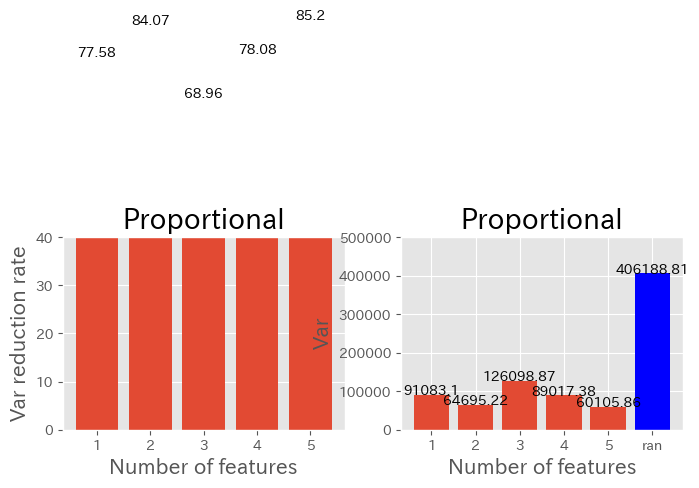

In [11]:
for exp in range(N_EXPERIMENT):
    print("exp_num : ", exp)
    for allocation_method in ALLOCATION_METHODS:
        plot_bars(
            dicts=[
                features_score_dict_dict_list[exp][allocation_method],
                features_variance_dict_dict_list[exp][allocation_method],
            ],
            titles=[
                f"{allocation_method}",
                f"{allocation_method}",
            ],
        )


##### 箱ひげ図

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_3716\3948261142.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)
C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_3716\3948261142.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels)


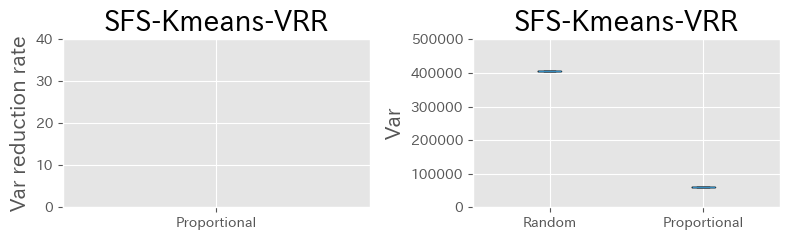

In [12]:
plot_boxplots(
    dicts=[all_reduction_rate_dict, all_variance_dict],
    titles=[
        f"{CLUSTERING_METHOD_NAME}",
        f"{CLUSTERING_METHOD_NAME}",
    ],
)


##### 結果

{'Proportional': [85.20248162576773]}
[{'Proportional': 60105.864345032955}]
exp_num :  0


C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_3716\3948261142.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


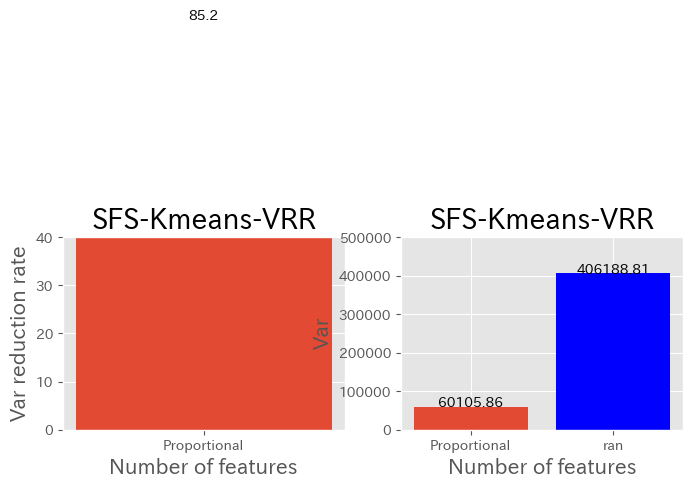

In [13]:
print(all_reduction_rate_dict)
final_reduction_rate_dict_list = []
for exp in range(N_EXPERIMENT):
    dict = {}
    for allocation_method in ALLOCATION_METHODS:
        dict[allocation_method] = all_reduction_rate_dict[allocation_method][exp]
    final_reduction_rate_dict_list.append(dict)

final_variance_dict_list = []
for exp in range(N_EXPERIMENT):
    dict = {}
    for allocation_method in ALLOCATION_METHODS:
        dict[allocation_method] = all_variance_dict[allocation_method][exp]
    final_variance_dict_list.append(dict)
print(final_variance_dict_list)


for exp in range(N_EXPERIMENT):
    print("exp_num : ", exp)
    plot_bars(
        dicts=[
            final_reduction_rate_dict_list[exp],
            final_variance_dict_list[exp],
        ],
        titles=[
            f"{CLUSTERING_METHOD_NAME}",
            f"{CLUSTERING_METHOD_NAME}",
        ],
    )


In [14]:
print("選択された特徴量", SELECTED_FEATURES_LIST)

選択された特徴量 [{'Proportional': [14, 2, 5, 6, 9]}]


------------------------------
--------------------------
### テストデータで評価

-------------
### クラスタリング

##### X-means

In [15]:
def compute_bic(X, kmeans):
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X, k_min=2, k_max=10):
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_kmeans = kmeans
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        if current_bic < best_bic:
            best_bic = current_bic
            best_kmeans = kmeans
    return best_kmeans


##### クラスタリング結果

In [16]:
cluster_label_dict_test_list = []
cluster_size_dict_test_list = []
N_CLUSTER_DICT_test_list = []


for exp in range(N_EXPERIMENT):
    cluster_label_dict_test = {}
    cluster_size_dict_test = {}
    N_CLUSTER_DICT_test = {}
    for allocation_method, features_list in SELECTED_FEATURES_LIST[exp].items():
        if CLUSTERING_METHOD == "kmeans":
            model = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE)
        if CLUSTERING_METHOD == "gmm":
            model = GaussianMixture(
                n_components=N_CLUSTERS, random_state=RANDOM_STATE, init_params="kmeans"
            )
        if CLUSTERING_METHOD == "xmeans":
            model = xmeans(X_test_std, k_min=K_MIN, k_max=K_MAX)

        labels = model.fit_predict(X_test_std[:, features_list])
        cluster_size = np.bincount(labels)
        n_clusters = len(np.unique(labels))

        cluster_label_dict_test[allocation_method] = labels
        cluster_size_dict_test[allocation_method] = cluster_size
        N_CLUSTER_DICT_test[allocation_method] = n_clusters

        print("[", allocation_method, "]")
        print("各層のクラスタサイズ : ", cluster_size_dict_test[allocation_method])
        print("クラスタ数：", N_CLUSTER_DICT_test[allocation_method])
        print()

    cluster_label_dict_test_list.append(cluster_label_dict_test)
    cluster_size_dict_test_list.append(cluster_size_dict_test)
    N_CLUSTER_DICT_test_list.append(N_CLUSTER_DICT_test)


[ Proportional ]
各層のクラスタサイズ :  [182 188   8 195  24  17 290   2   2  82]
クラスタ数： 10



----------------------
### 標本配分

##### 基底クラス

In [17]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self, sample_size: int, H: int, random_state: int, allocation_method: str
    ):
        self.sample_size = sample_size
        self.H = H
        self.random_state = random_state
        self.allocation_method = allocation_method

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError

    def clustering(self, X: NDArray) -> tuple[NDArray, NDArray]:
        cluster_label = cluster_label_dict_test[allocation_method]
        cluster_size = cluster_size_dict_test[allocation_method]

        # インスタンス変数として設定
        self.cluster_label = cluster_label
        self.N = cluster_size

        return cluster_label, cluster_size


##### Proportional

In [18]:
class Proportional(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.sample_size).astype(int)

        if n.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.sample_size

        if n.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n[np.argmax(n)] += -n.sum() + self.sample_size

        return n


##### Post

In [19]:
class Post(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])

        return n  # （例）n=[標本サイズ]


##### Optimal

In [20]:
class Optimal(BaseAllocation):
    def __init__(
        self,
        sample_size: int,
        H: int,
        m: NDArray,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
        random_state: int = 0,
        allocation_method: str = "Post",
    ):
        super().__init__(
            sample_size, H, random_state, allocation_method
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.m = m  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array([np.var(y[self.cluster_label == h]) for h in range(self.H)])
        d = (self.N**2) * S  # (H, )
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N.copy()
        I = np.arange(self.H)  # noqa #クラスタのインデックス
        while (n.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(self.H)
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(n >= self.m), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"


##### ポリシー生成

In [21]:
# 各ポリシーの生成を行う関数
def create_policies(
    allocation_methods: list,
    sample_size: int,
    H_dict: dict,
    random_state: int,
    m_value: int,
):  # -> dict[list[str] : list[BaseAllocation]]:
    policies_dict = {}
    policies: list[BaseAllocation] = []
    if "Proportional" in allocation_methods:
        policies.append(
            Proportional(
                sample_size=sample_size,
                H=H_dict["Proportional"],
                random_state=random_state,
                allocation_method="Proportional",
            )
        )
    if "Post" in allocation_methods:
        policies.append(
            Post(
                sample_size=sample_size,
                H=H_dict["Post"],
                random_state=random_state,
                allocation_method="Post",
            )
        )
    if "Optimal" in allocation_methods:
        policies.append(
            Optimal(
                sample_size=sample_size,
                H=H_dict["Optimal"],
                random_state=random_state,
                m=np.full(H_dict["Optimal"], m_value),
                M=None,
                allocation_method="Optimal",
            )
        )
    policies_dict[CLUSTERING_METHOD_NAME] = policies

    return policies_dict


policies_dict_list = []
for exp in range(N_EXPERIMENT):
    policies_dict = create_policies(
        allocation_methods=ALLOCATION_METHODS,
        sample_size=SAMPLE_SIZE,
        H_dict=N_CLUSTER_DICT_test_list[exp],
        random_state=RANDOM_STATE,
        m_value=m_VALUE,
    )
    policies_dict_list.append(policies_dict)

print("policies", policies_dict_list)


policies [{'SFS-Kmeans-VRR': [<__main__.Proportional object at 0x000001173B1B2240>]}]


##### 標本配分の計算

In [22]:
allocations_dict_list = []
for exp in range(N_EXPERIMENT):
    allocations_dict = {}
    for name, policies in policies_dict_list[exp].items():
        # それぞれの戦略で各クラスタの標本数を求解
        allocations: list[dict] = []  # 各戦略の実行結果が辞書形式で追加される
        for policy in policies:
            # policyを用いてXをクラスタリング
            cluster_label, _ = policy.clustering(X_test_std)
            n = policy.solve(X_test_std, y_test)
            allocations.append(
                {
                    "policy": policy.__class__.__name__,
                    "n": n,
                    "cluster_label": cluster_label,
                }
            )
        allocations_dict[name] = allocations
    allocations_dict_list.append(allocations_dict)


------------
### 標本抽出と誤差分散削減率の計算

##### 母平均を推定する関数

In [23]:
def estimate_y_mean(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    """実際にサンプリングを行って目的変数の平均を推定

    Args:
        n (NDArray): 各クラスタの標本数 (H, )
        cluster_label (NDArray): クラスタラベル (N, )
        y (NDArray): 目的変数 (N, )

    Returns:
        NDArray: 推定された目的変数の平均

    Note:
        N: データ数
        H: クラスタ数
    """
    # cluster_labelからユニークなクラスタラベルを取得し、母集団の各クラスタのサイズNを取得
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        if n[h] != 0:
            y_cluster = y[cluster_label == h]
            if n[h] <= len(y_cluster):
                sample: NDArray = np.random.choice(y_cluster, n[h], replace=False)
                y_sample_mean = sample.mean()  # サンプリングした標本の平均
                y_hat += y_sample_mean * weights[h]

    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> NDArray:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0
    indices = np.arange(N.sum())
    y_array = np.array(y.tolist())
    n_indices = np.random.choice(indices, n[0], replace=False)
    n_label = np.array([cluster_label[i] for i in n_indices])
    n_new_labels = np.unique(n_label)
    for h in n_new_labels:
        index = np.where(n_label == h)[0]
        sample = y_array[n_indices[index]]
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat


##### 誤差分散削減率の計算をする関数

In [24]:
def cauculate_reduction_rate(
    X: pd.DataFrame,
    y: pd.DataFrame,
    policies_dict: dict,
    random_std: float,
    exp_num: str,
) -> dict:
    reduction_rate_dict = {}
    error_variance_dict = {}

    # 各戦略の標本数に基づいて目的変数の平均を推定
    y_hats_dict = {}
    for name, allocations in allocations_dict_list[exp_num].items():
        y_hats = []
        for i in range(N_TRIALS):
            for allocation in allocations:
                if allocation["policy"] == "Post":
                    y_hat = estimate_y_mean_post(
                        allocation["n"], allocation["cluster_label"], y
                    )
                else:
                    y_hat = estimate_y_mean(
                        allocation["n"], allocation["cluster_label"], y
                    )
                y_hats.append(
                    {
                        "policy": allocation["policy"],
                        "y_hat": y_hat,
                        "random_state": i,
                    }
                )
        y_hats_dict[name] = y_hats

    for name, y_hats in y_hats_dict.items():
        y_hat_df = pd.DataFrame(y_hats)
        if CRITERION == "EVRR":
            y_hat_df["error"] = (
                y_hat_df["y_hat"] - y.mean()
            )  # 真の平均からの誤差をerrorカラムに追加
            # random_allocation以外の誤差分散
            non_random_allocation_std = y_hat_df.groupby("policy")["error"].var()
            # 削減率
            reduction_rate = (1 - non_random_allocation_std / random_std) * 100
        if CRITERION == "Var" or "VRR":
            non_random_allocation_std = y_hat_df.groupby("policy")["y_hat"].var()
            reduction_rate = (1 - non_random_allocation_std / random_std) * 100

        reduction_rate = reduction_rate.reindex(
            [policy.__class__.__name__ for policy in policies]
        )

        error_variance = pd.concat(
            [
                pd.Series(random_std, index=["Random"]),
                non_random_allocation_std,
            ]
        )
        reduction_rate_dict[name] = reduction_rate
        error_variance_dict[name] = error_variance
    return reduction_rate_dict, error_variance_dict


##### ランダムの誤差分散を計算

In [25]:
RANDOM_STD_LIST = []
for exp in range(N_EXPERIMENT):
    np.random.seed(exp)
    y_hats = []
    for random_state in range(N_TRIALS):
        sample = np.random.choice(y_test, SAMPLE_SIZE, replace=False)
        y_hat_random = sample.mean()
        y_hats.append(y_hat_random)
    if CRITERION == "EVRR":
        errors = np.array(y_hats) - y_test.mean()
        random_std = errors.var()
    if CRITERION == "Var" or "VRR":
        random_std = np.array(y_hats).var()
    RANDOM_STD_LIST.append(random_std)
print(RANDOM_STD_LIST)


[129710.286424]


##### 層化抽出の誤差分散を計算

In [26]:
all_reduction_rate = []
all_variance = []
for exp in range(N_EXPERIMENT):
    np.random.seed(exp)
    reduction_rate_dict, variance_dict = cauculate_reduction_rate(
        X_test_std, y_test, policies_dict_list[exp], RANDOM_STD_LIST[exp], exp_num=exp
    )
    all_reduction_rate.append(reduction_rate_dict)
    all_variance.append(variance_dict)

print(all_reduction_rate)


[{'SFS-Kmeans-VRR': policy
Proportional   -27.543485
Name: y_hat, dtype: float64}]


In [27]:
results_reduction_rate_list = []
results_variance_list = []
for exp in range(N_EXPERIMENT):
    results_reduction_rate = {}
    results_variance = {}

    for name, policy in all_reduction_rate[exp].items():
        for allocation_method in ALLOCATION_METHODS:
            results_reduction_rate[allocation_method] = policy[allocation_method]

    results_variance["Random"] = RANDOM_STD_LIST[exp]
    for name, policy in all_variance[exp].items():
        for allocation_method in ALLOCATION_METHODS:
            results_variance[allocation_method] = policy[allocation_method]

    results_reduction_rate_list.append(results_reduction_rate)
    results_variance_list.append(results_variance)

print(results_reduction_rate_list)


[{'Proportional': -27.54348483052351}]


exp_num :  0


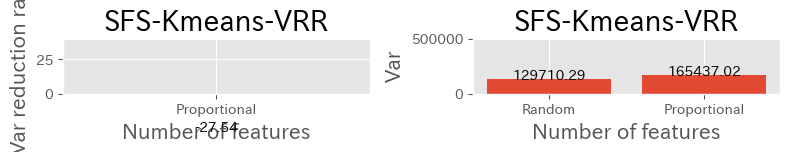

In [28]:
for exp in range(N_EXPERIMENT):
    print("exp_num : ", exp)
    plot_bars(
        dicts=[
            results_reduction_rate_list[exp],
            results_variance_list[exp],
        ],
        titles=[
            f"{CLUSTERING_METHOD_NAME}",
            f"{CLUSTERING_METHOD_NAME}",
        ],
        Var_eva="yes",
    )
